In [ ]:
import pandas as pd

# Load dataset
file_path = "/content/incidents_part1_part2.csv"
df = pd.read_csv(file_path)

# Display basic info
print(df.info())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17501 entries, 0 to 17500
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              17465 non-null  object 
 1   cartodb_id            17501 non-null  int64  
 2   the_geom_webmercator  17464 non-null  object 
 3   objectid              17501 non-null  int64  
 4   dc_dist               17501 non-null  int64  
 5   psa                   17496 non-null  object 
 6   dispatch_date_time    17501 non-null  object 
 7   dispatch_date         17501 non-null  object 
 8   dispatch_time         17501 non-null  object 
 9   hour                  17500 non-null  float64
 10  dc_key                17501 non-null  float64
 11  location_block        17501 non-null  object 
 12  ucr_general           17501 non-null  int64  
 13  text_general_code     17501 non-null  object 
 14  point_x               17464 non-null  float64
 15  point_y            

In [ ]:
# Fill missing numerical values with the median
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Verify no missing values remain
print(df.isnull().sum())


the_geom                0
cartodb_id              0
the_geom_webmercator    0
objectid                0
dc_dist                 0
psa                     0
dispatch_date_time      0
dispatch_date           0
dispatch_time           0
hour                    0
dc_key                  0
location_block          0
ucr_general             0
text_general_code       0
point_x                 0
point_y                 0
lat                     0
lng                     0
dtype: int64


In [ ]:
from scipy.stats import skew, kurtosis

# Compute skewness and kurtosis
skewness_values = df[numerical_cols].skew()
kurtosis_values = df[numerical_cols].kurtosis()

# Print results
print(pd.DataFrame({'Skewness': skewness_values, 'Kurtosis': kurtosis_values}))


               Skewness      Kurtosis
cartodb_id    -4.376055     20.250841
objectid      -0.512934     -0.790035
dc_dist        1.274764      4.384720
hour          -0.444810     -0.252659
dc_key        -1.333437     21.167637
ucr_general    1.610171      1.571368
point_x      129.991065  17096.289361
point_y     -127.601630  16678.760020
lat         -127.601630  16678.760020
lng          129.991065  17096.289361


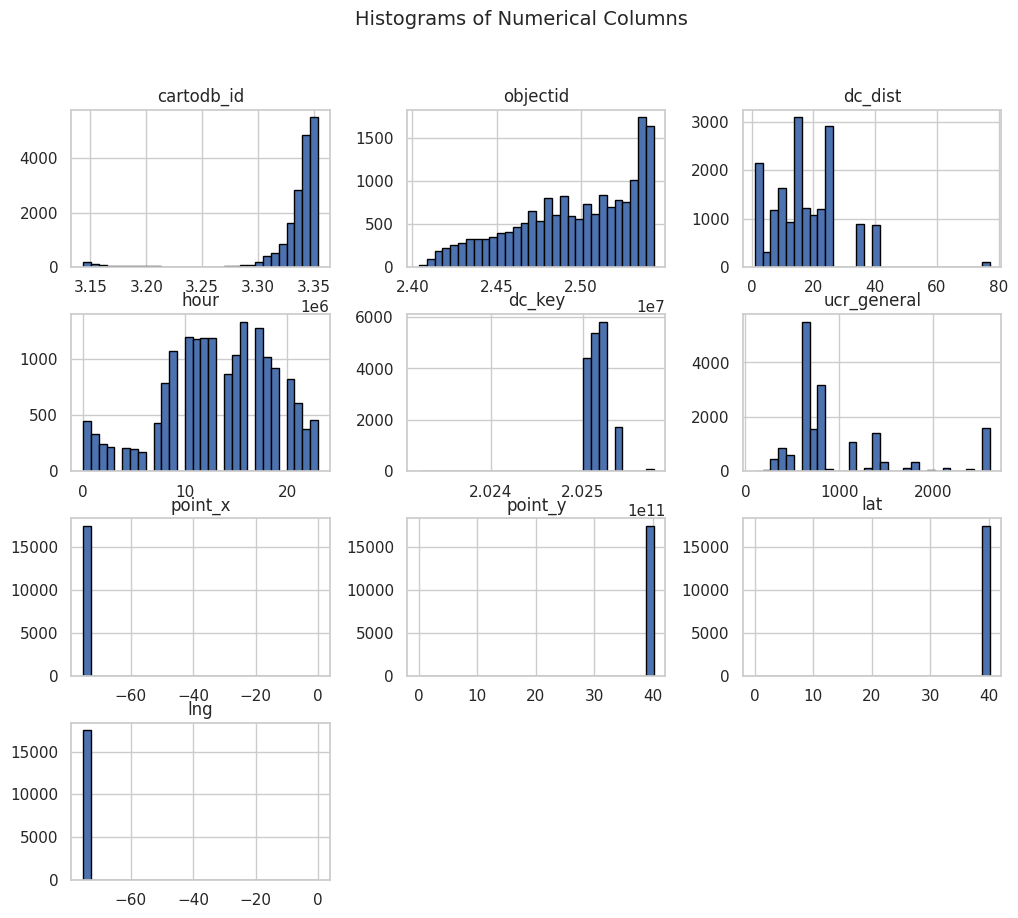

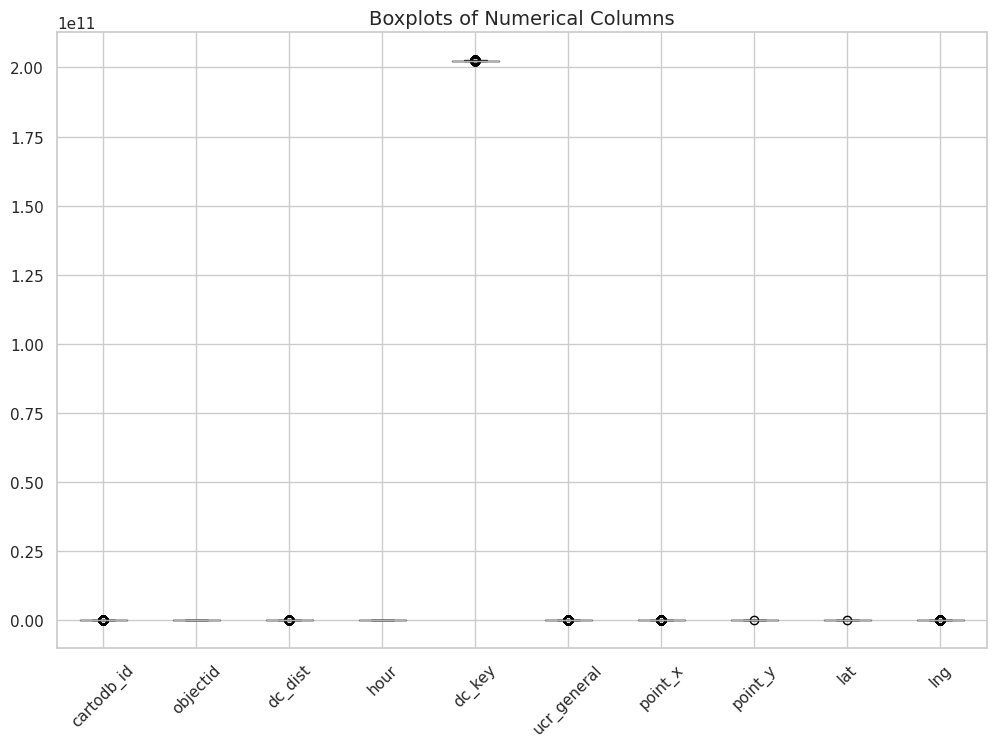

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot histograms
df[numerical_cols].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=14)
plt.show()

# Plot boxplots
plt.figure(figsize=(12, 8))
df[numerical_cols].boxplot(rot=45)
plt.title("Boxplots of Numerical Columns", fontsize=14)
plt.show()


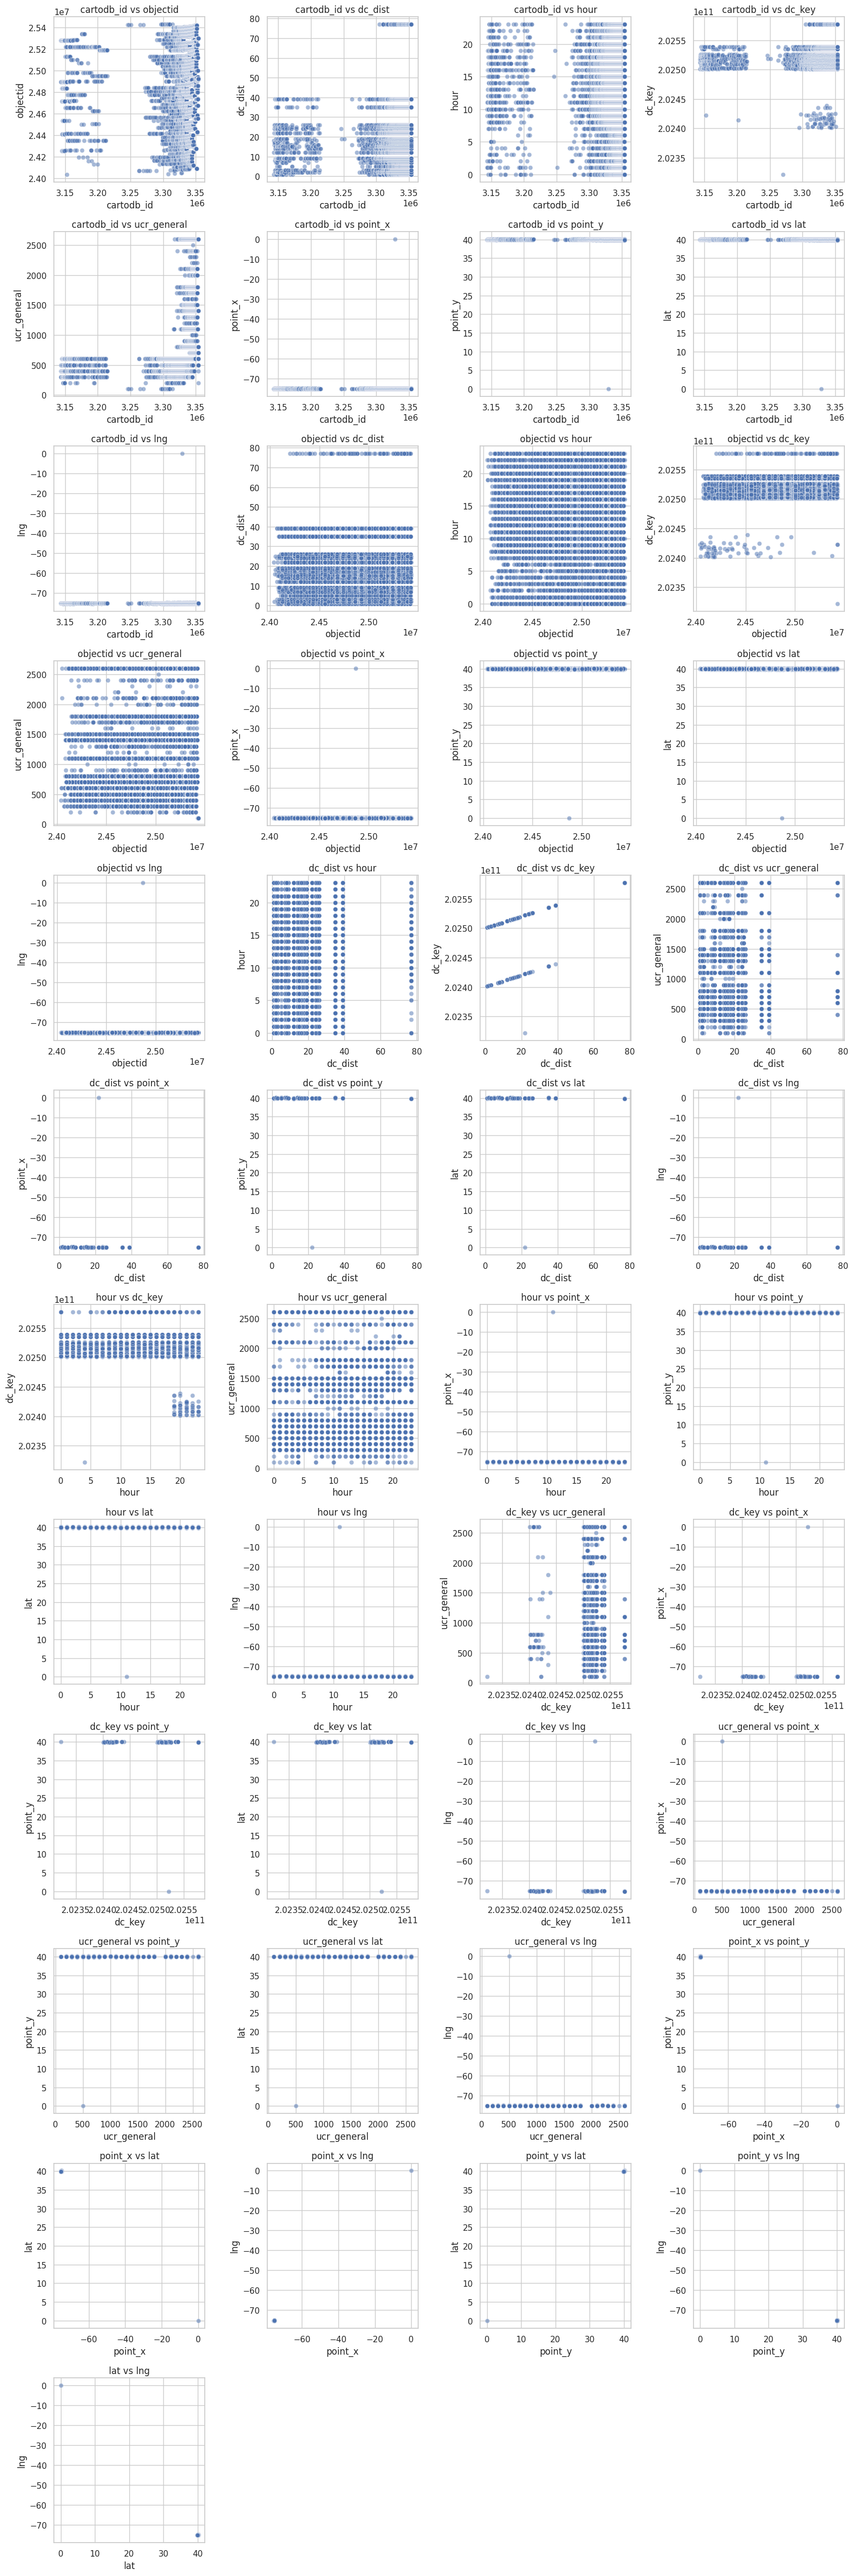

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Generate all possible column pairs
column_pairs = list(itertools.combinations(numerical_cols, 2))

# Determine dynamic rows and columns based on total plots
num_plots = len(column_pairs)
num_cols = 4  # Fixing 4 columns for better visualization
num_rows = math.ceil(num_plots / num_cols)  # Auto-adjust rows

# Create figure
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Generate scatter plots
for i, (col1, col2) in enumerate(column_pairs, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(x=df[col1], y=df[col2], alpha=0.5)
    plt.title(f"{col1} vs {col2}")

plt.tight_layout()
plt.show()


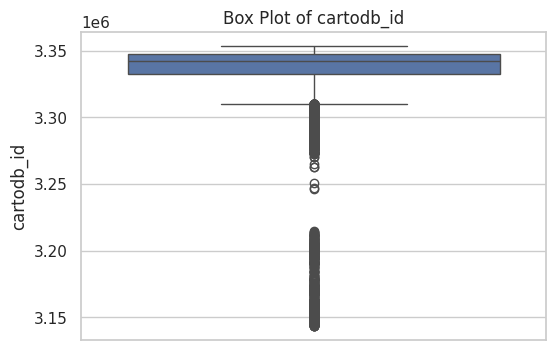

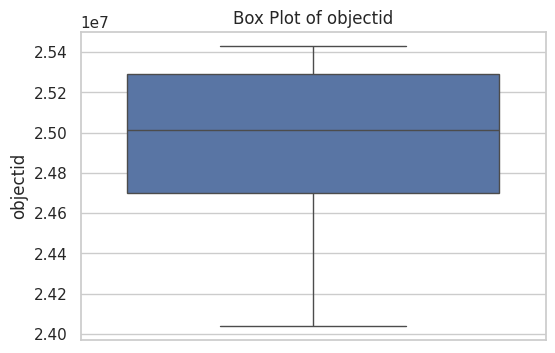

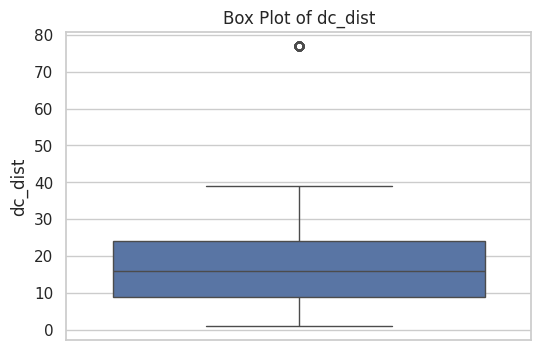

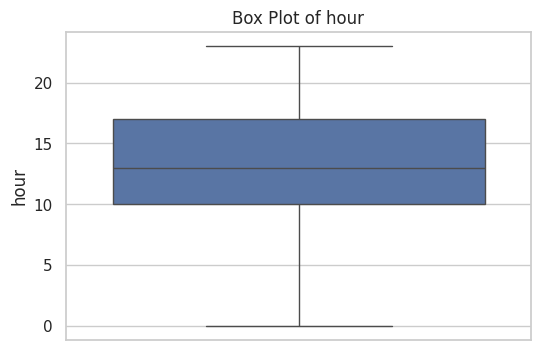

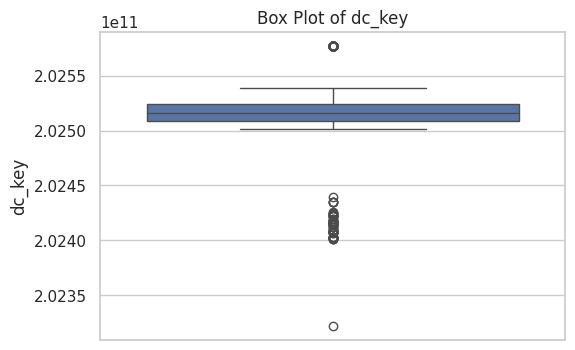

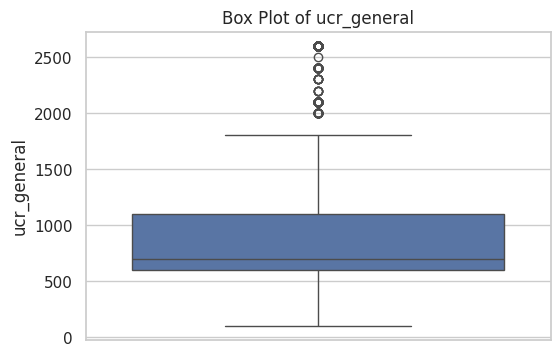

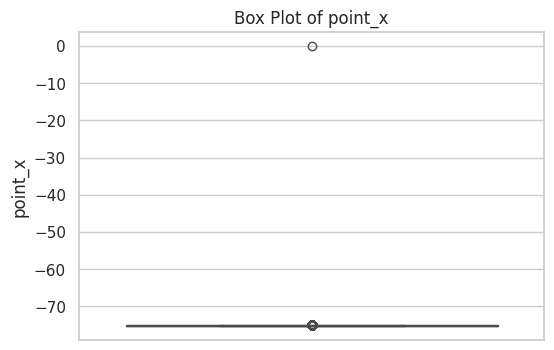

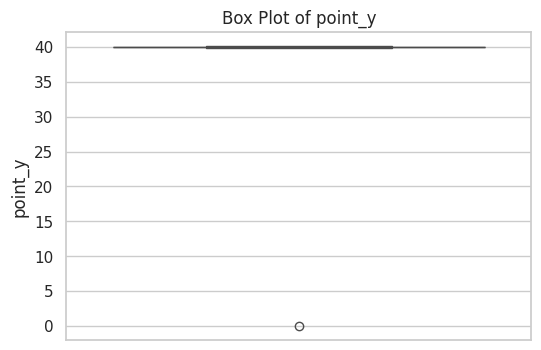

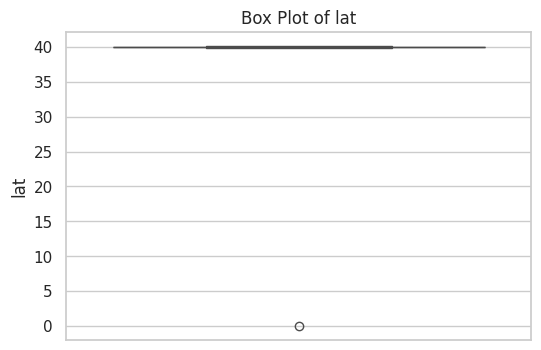

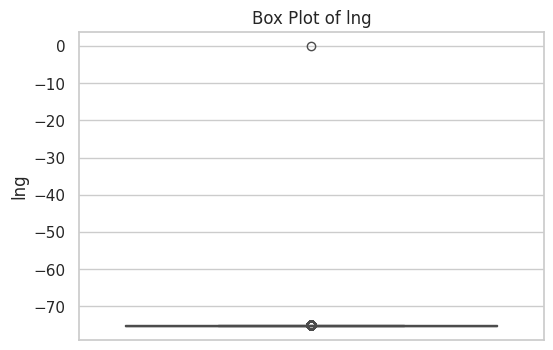

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate through numerical columns and create individual box plots
for col in numerical_cols:
    plt.figure(figsize=(6, 4))  # Create a new figure for each plot
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot of {col}")
    plt.show()


In [ ]:
import numpy as np

# Function to remove outliers using IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only data within bounds
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Create a copy of the original dataset
df_cleaned = df.copy()

# Apply outlier removal to all numerical columns
for col in numerical_cols:
    df_cleaned = remove_outliers(df_cleaned, col)


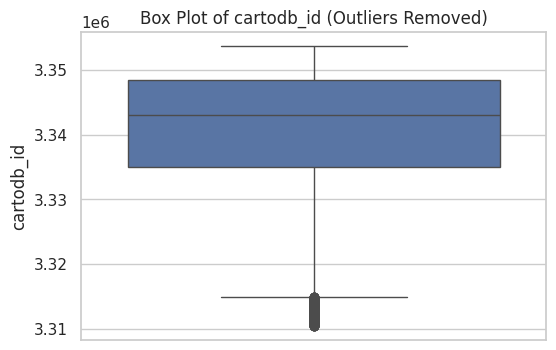

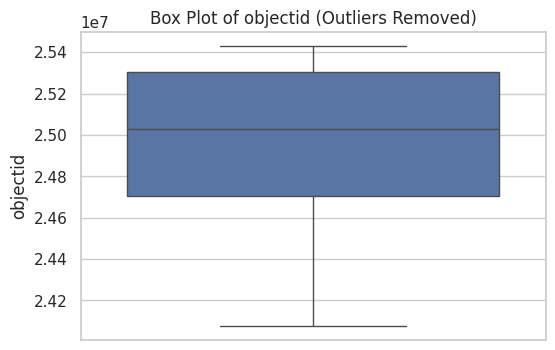

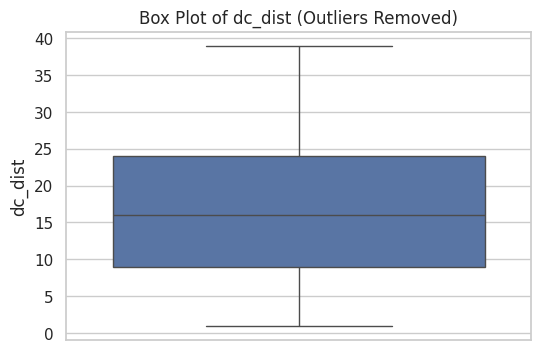

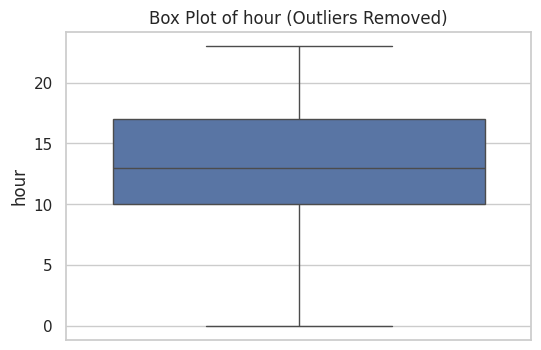

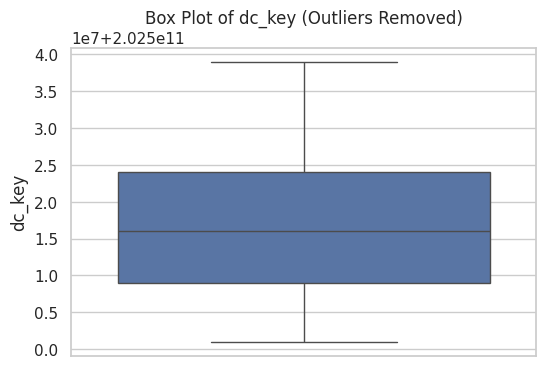

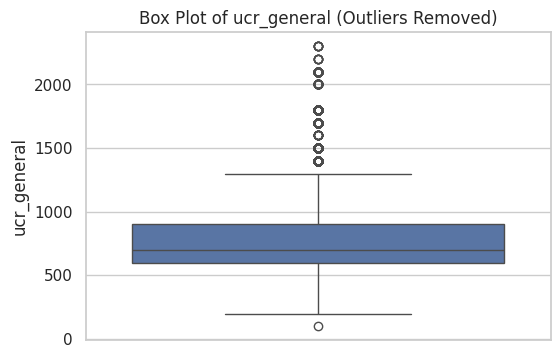

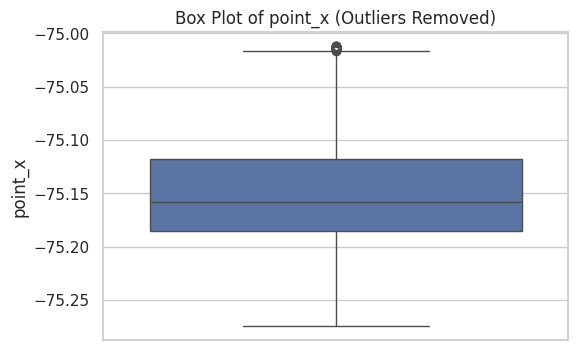

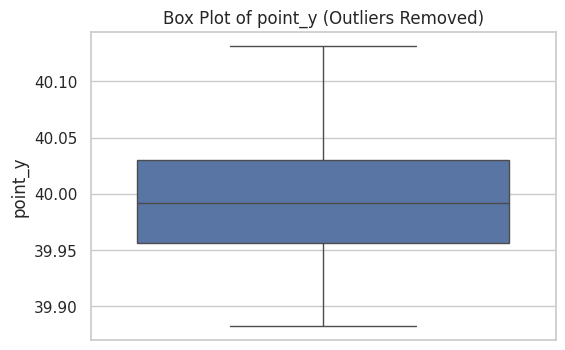

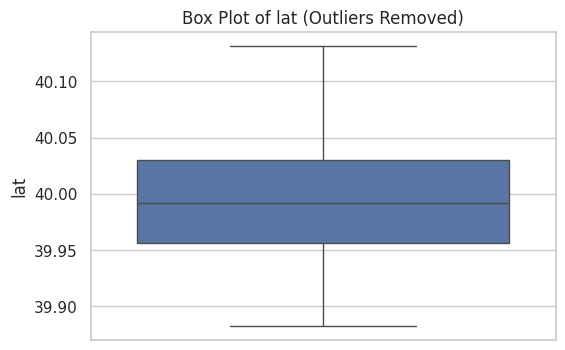

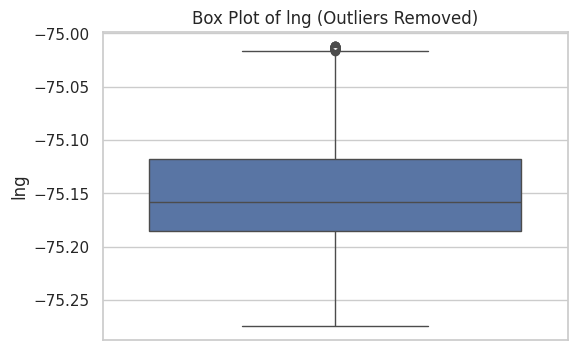

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate box plots after outlier removal
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_cleaned[col])
    plt.title(f"Box Plot of {col} (Outliers Removed)")
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Select features and target
features = ["hour", "dc_dist", "ucr_general"]  # Example feature selection
target = "text_general_code"  # Classify crime type

# Encode categorical target variable
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name}: Accuracy = {accuracy:.4f}")


Random Forest: Accuracy = 0.8723


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.3802
Support Vector Machine: Accuracy = 0.9060


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select features and target
features = ["hour", "dc_dist", "ucr_general"]  # Example feature selection
target = "text_general_code"  # Classify crime type

# Encode categorical target variable
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest Accuracy: 0.8795


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


Logistic Regression Accuracy: 0.3802


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.svm import SVC

# Initialize and train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Support Vector Machine Accuracy: {svm_accuracy:.4f}")


Support Vector Machine Accuracy: 0.9060


In [ ]:
# Print model comparison
model_accuracies = {
    "Random Forest": rf_accuracy,
    "Logistic Regression": lr_accuracy,
    "Support Vector Machine": svm_accuracy
}

for model, acc in model_accuracies.items():
    print(f"{model}: Accuracy = {acc:.4f}")

# Find the best model
best_model = max(model_accuracies, key=model_accuracies.get)
print(f"Best performing model: {best_model} with {model_accuracies[best_model]:.4f} accuracy.")


Random Forest: Accuracy = 0.8795
Logistic Regression: Accuracy = 0.3802
Support Vector Machine: Accuracy = 0.9060
Best performing model: Support Vector Machine with 0.9060 accuracy.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Initialize dictionary for storing results
model_metrics = {}

# Function to train, predict, and evaluate model
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions, average="weighted")
    rec = recall_score(y_test, predictions, average="weighted")

    model_metrics[model_name] = {"Accuracy": acc, "Precision": prec, "Recall": rec}
    print(f"{model_name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}")

# Train and evaluate models
evaluate_model(RandomForestClassifier(), "Random Forest")
evaluate_model(LogisticRegression(max_iter=1000), "Logistic Regression")
evaluate_model(SVC(), "Support Vector Machine")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest: Accuracy=0.8777, Precision=0.8622, Recall=0.8777


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression: Accuracy=0.3802, Precision=0.2332, Recall=0.3802
Support Vector Machine: Accuracy=0.9060, Precision=0.8359, Recall=0.9060


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


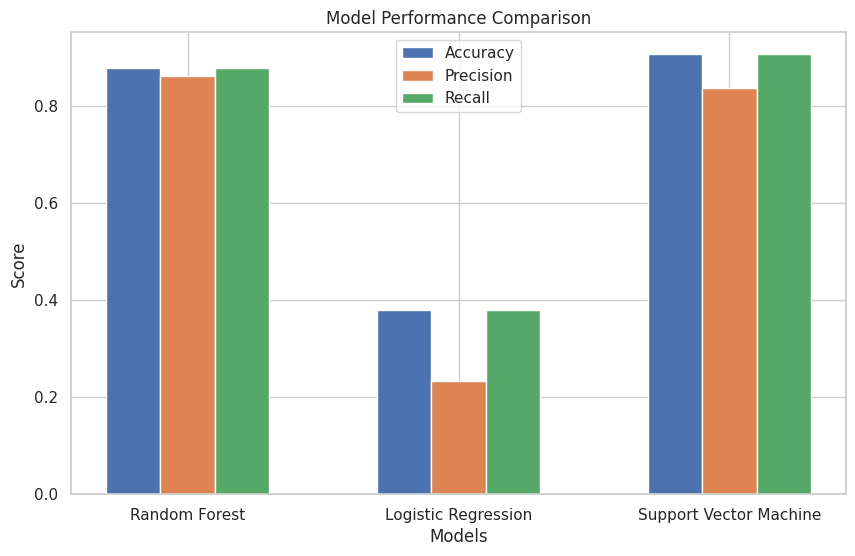

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metric values for plotting
models = list(model_metrics.keys())
accuracy = [model_metrics[m]["Accuracy"] for m in models]
precision = [model_metrics[m]["Precision"] for m in models]
recall = [model_metrics[m]["Recall"] for m in models]

# Set bar width
bar_width = 0.2
index = np.arange(len(models))

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label="Accuracy")
plt.bar(index + bar_width, precision, bar_width, label="Precision")
plt.bar(index + 2 * bar_width, recall, bar_width, label="Recall")

# Labeling
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(index + bar_width, models)
plt.title("Model Performance Comparison")
plt.legend()

plt.show()


In [ ]:
from statsmodels.stats.weightstats import ztest

# Example: Z-test between two numerical columns
z_stat, p_val = ztest(df[numerical_cols[0]], df[numerical_cols[1]])
print("Z-statistic:", z_stat)
print("P-value:", p_val)


Z-statistic: -7941.5200592341625
P-value: 0.0


In [ ]:
from scipy.stats import ttest_ind

# Independent two-sample T-test between first two numerical columns
t_stat, p_val = ttest_ind(df[numerical_cols[0]], df[numerical_cols[1]])
print("T-Statistic:", t_stat)
print("P-value:", p_val)


T-Statistic: -7941.520059234164
P-value: 0.0


In [ ]:
from scipy.stats import f_oneway

# ANOVA Test across the first three numerical columns
f_stat, p_val = f_oneway(df[numerical_cols[0]], df[numerical_cols[1]], df[numerical_cols[2]])
print("F-Statistic:", f_stat)
print("P-value:", p_val)


F-Statistic: 74288841.77807467
P-value: 0.0


In [ ]:
# Define features and label
X = df[numerical_cols]
y = df['binary_label'] # This line throws the error

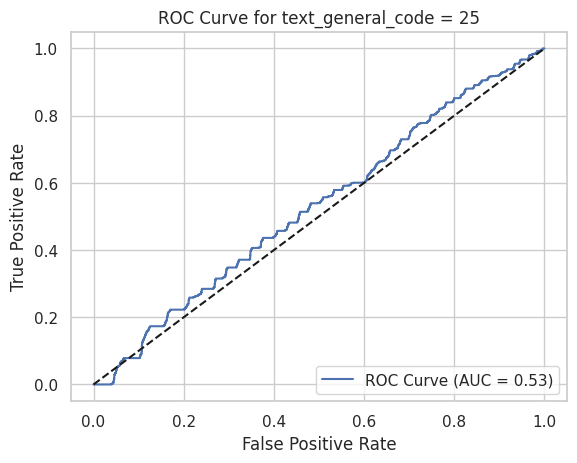

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Use most frequent class (25) as positive class
df['binary_label'] = (df['text_general_code'] == 25).astype(int)

# Use only numerical columns for features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['binary_label']).columns
X = df[numerical_cols]
y = df['binary_label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for text_general_code = 25')
plt.legend(loc="lower right")
plt.show()
